<a href="https://colab.research.google.com/github/sneha9730/Face-Emotion-Detection/blob/main/notebooks/SqueezeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate,GlobalAveragePooling2D, Activation,Dropout, BatchNormalization, LeakyReLU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import os

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d msambare/fer2013

!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
def fire_module(x, squeeze_filters, expand_filters):
    squeeze = Conv2D(squeeze_filters, (1, 1), padding='same', kernel_initializer='he_normal')(x)
    squeeze = BatchNormalization()(squeeze)
    squeeze = LeakyReLU()(squeeze)
    expand1x1 = Conv2D(expand_filters, (1, 1), padding='same', kernel_initializer='he_normal')(squeeze)
    expand1x1 = BatchNormalization()(expand1x1)
    expand1x1 = LeakyReLU()(expand1x1)
    expand3x3 = Conv2D(expand_filters, (3, 3), padding='same', kernel_initializer='he_normal')(squeeze)
    expand3x3 = BatchNormalization()(expand3x3)
    expand3x3 = LeakyReLU()(expand3x3)
    output = Concatenate()([expand1x1, expand3x3])
    return output

In [ ]:
def build_squeezenet(input_shape=(48, 48, 1), num_classes=7):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = fire_module(x, 24, 96)
    x = fire_module(x, 24, 96)

    x = fire_module(x, 32, 128)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)

    x = Dropout(0.5)(x)
    x = Conv2D(128, (1, 1), padding='same', kernel_initializer='he_normal')(x)
    x = LeakyReLU()(x)
    x = GlobalAveragePooling2D()(x)

    x = Dense(64, activation='relu')(x)  # Extra dense layer for capacity
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

In [ ]:
batch_size = 64

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=10
)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)

Found 22968 images belonging to 7 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

Found 5741 images belonging to 7 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 7178 images belonging to 7 classes.


In [ ]:
model = build_squeezenet(input_shape=(48, 48, 1), num_classes=7)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 24, 24,    │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_23      │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 12, 12,    │          0 │ leaky_re_lu_23[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 12, 12,    │      1,040 │ max_pooling2d_3[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │         64 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_24      │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 12, 12,    │      1,088 │ leaky_re_lu_24[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 12, 12,    │      9,280 │ leaky_re_lu_24[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_25      │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_26      │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 12, 12,    │          0 │ leaky_re_lu_25[0… │
│ (Concatenate)       │ 128)              │            │ leaky_re_lu_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 12, 12,    │      2,064 │ concatenate_7[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │         64 │ conv2d_27[0][0] 

 Total params: 502,631 (1.92 MB)

 Trainable params: 498,471 (1.90 MB)

 Non-trainable params: 4,160 (16.25 KB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 77s 114ms/step - accuracy: 0.2932 - loss: 1.7398 - val_accuracy: 0.3714 - val_loss: 1.7017
Epoch 2/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.4269 - loss: 1.4752 - val_accuracy: 0.4335 - val_loss: 1.4972
Epoch 3/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.4804 - loss: 1.3582 - val_accuracy: 0.4682 - val_loss: 1.3826
Epoch 4/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.4996 - loss: 1.3085 - val_accuracy: 0.4888 - val_loss: 1.3389
Epoch 5/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.5146 - loss: 1.2617 - val_accuracy: 0.4957 - val_loss: 1.3363
Epoch 6/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.5351 - loss: 1.2186 - val_accuracy: 0.5020 - val_loss: 1.2964
Epoch 7/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.5446 - loss: 1.1879 - val_accuracy: 0.5184 - val_loss: 1.2527
Epoch 8/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.5596 - loss: 1.1608 - val_accura

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5575 - loss: 1.2202
Test Accuracy: 0.5442


In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f'Final Train Accuracy: {final_train_acc:.4f}')
print(f'Final Validation Accuracy: {final_val_acc:.4f}')

Final Train Accuracy: 0.6348
Final Validation Accuracy: 0.5422


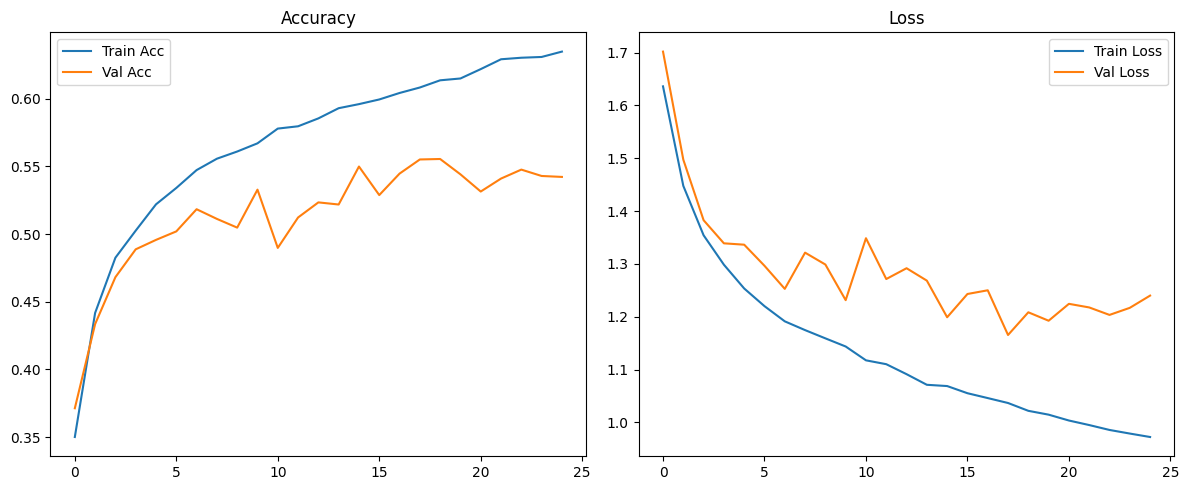

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step
              precision    recall  f1-score   support

       angry       0.35      0.70      0.47       958
     disgust       0.45      0.23      0.31       111
        fear       0.45      0.25      0.32      1024
       happy       0.88      0.67      0.76      1774
     neutral       0.53      0.48      0.50      1233
         sad       0.52      0.38      0.44      1247
    surprise       0.56      0.82      0.67       831

    accuracy                           0.54      7178
   macro avg       0.53      0.51      0.50      7178
weighted avg       0.58      0.54      0.54      7178



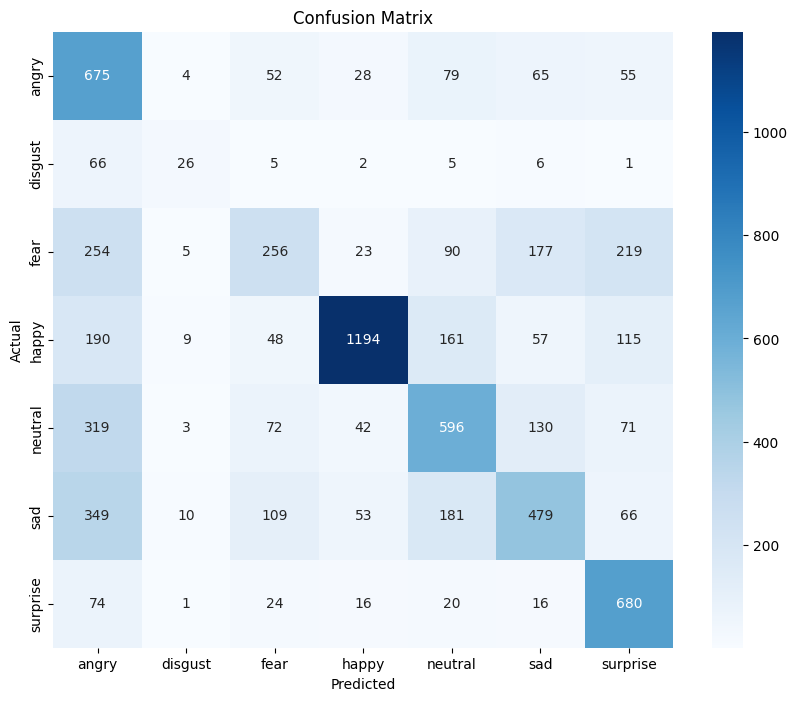

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


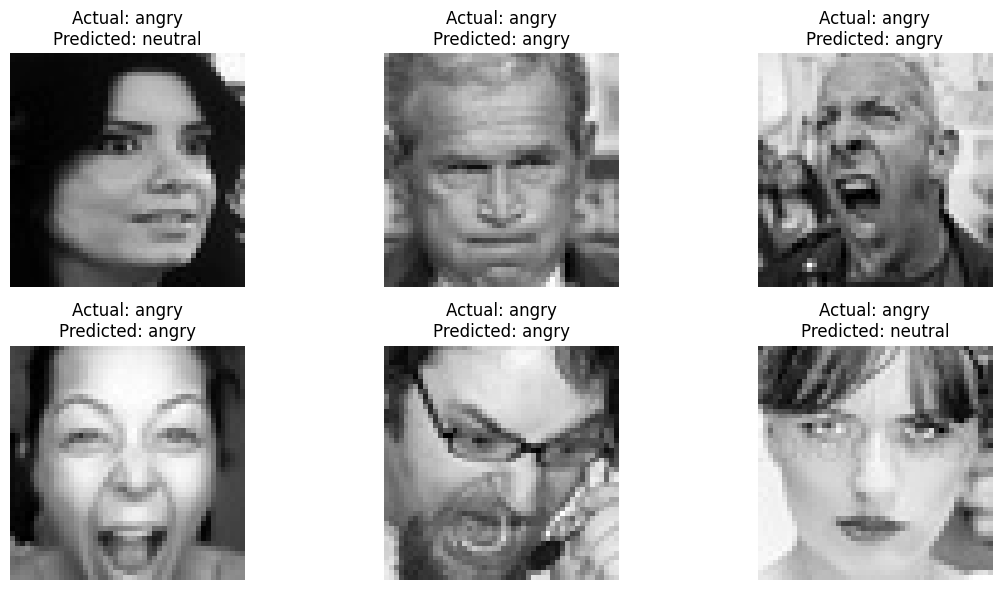

In [ ]:
import random

class_indices = {v: k for k, v in test_generator.class_indices.items()}
images, labels = next(test_generator)

pred_probs = model.predict(images)
predictions = np.argmax(pred_probs, axis=1)

plt.figure(figsize=(12, 6))
for i in range(6):
    idx = random.randint(0, len(images)-1)
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[idx].squeeze(), cmap='gray')
    actual = class_indices[np.argmax(labels[idx])]
    predicted = class_indices[predictions[idx]]
    plt.title(f"Actual: {actual}\nPredicted: {predicted}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
model.save("squeezenet_fer2013.h5")